In [2]:
import os
import sys
import datetime as dt
import importlib
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row, SparkSession
from pyspark.sql import functions as F
from pyspark import SparkConf
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython
from copy import deepcopy
from tqdm import trange, tqdm

mpl.rcParams['figure.facecolor'] = 'white'

import warnings

import pandas as pd
import swifter
pd.set_option('display.max_columns', None)
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import pyspark
print(pyspark.__version__)
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '80g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '40g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", -1)\
        .config("spark.driver.maxResultSize", 0)\
        .config("spark.shuffle.spill", "true")\
        .getOrCreate()

3.3.0
22/11/16 16:22:35 WARN Utils: Your hostname, scope-vanderbilt resolves to a loopback address: 127.0.1.1; using 10.2.218.69 instead (on interface enp8s0)
22/11/16 16:22:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/16 16:22:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/16 16:22:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [230]:
def get_apc_data_for_date(filter_date):
    print("Running this...")
    filepath = '/home/jptalusan/mta_stationing_problem/data/processed/apc_weather_gtfs_20220921.parquet'
    apcdata = spark.read.load(filepath)
    apcdata.createOrReplaceTempView("apc")

    plot_date = filter_date.strftime('%Y-%m-%d')
    get_columns = ['trip_id', 'transit_date', 'arrival_time', 'scheduled_time',
                'block_abbr', 'stop_sequence', 'stop_id_original',
                'vehicle_id', 'vehicle_capacity',
                'load', 'ons', 'offs', 'zero_load_at_trip_end',
                'route_direction_name', 'route_id', 'overload_id']
    get_str = ", ".join([c for c in get_columns])
    query = f"""
    SELECT {get_str}
    FROM apc
    WHERE (transit_date == '{plot_date}')
    ORDER BY arrival_time
    """
    apcdata = spark.sql(query)
    apcdata = apcdata.withColumn("route_id_dir", F.concat_ws("_", apcdata.route_id, apcdata.route_direction_name))
    # apcdata = apcdata.withColumn("day", F.dayofmonth(apcdata.arrival_time))
    apcdata = apcdata.drop("route_direction_name")
    apcdata = apcdata.withColumn("load", F.when(apcdata.load < 0, 0).otherwise(apcdata.load))
    apcdata = apcdata.na.fill(value=0,subset=["zero_load_at_trip_end"])
    return apcdata

In [231]:
DATE = '2022-03-05'
date_to_predict = dt.datetime.strptime(DATE, '%Y-%m-%d')
DATE_STR = date_to_predict.strftime('%Y%m%d')
apcdata = get_apc_data_for_date(date_to_predict)

Running this...


In [232]:
df = apcdata.toPandas()

In [233]:
trip_ids = ['260574', '259635', '259845']
with pd.option_context('display.max_rows', 20, 'display.max_columns', None):
    display(df[df['trip_id'].isin(trip_ids)].sort_values(['trip_id', 'vehicle_id', 'scheduled_time','stop_sequence']))

,trip_id,transit_date,arrival_time,scheduled_time,block_abbr,stop_sequence,stop_id_original,vehicle_id,vehicle_capacity,load,ons,offs,zero_load_at_trip_end,route_id,overload_id,route_id_dir
28579,259635,2022-03-05,2022-03-05 22:13:40,2022-03-05 22:15:00,1800,1,MCC4_13,1914,40.0,6.0,12.0,6.0,0,18,2,18_FROM DOWNTOWN
819,259635,2022-03-05,NaT,2022-03-05 22:15:29,1800,2,4AVDEASN,1914,40.0,6.0,0.0,0.0,0,18,2,18_FROM DOWNTOWN
2478,259635,2022-03-05,NaT,2022-03-05 22:15:51,1800,3,4AVUNISN,1914,40.0,6.0,0.0,0.0,0,18,2,18_FROM DOWNTOWN
941,259635,2022-03-05,NaT,2022-03-05 22:16:07,1800,4,4AARCADE,1914,40.0,6.0,0.0,0.0,0,18,2,18_FROM DOWNTOWN
28635,259635,2022-03-05,2022-03-05 22:19:30,2022-03-05 22:16:31,1800,5,4AVCHUSN,1914,40.0,6.0,0.0,0.0,0,18,2,18_FROM DOWNTOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7069,260574,2022-03-05,2022-03-05 08:15:04,2022-03-05 07:56:00,2311,28,1SSPRSM,2008,40.0,9.0,0.0,0.0,1,23,1,23_TO DOWNTOWN
7072,260574,2022-03-05,2022-03-05 08:15:14,2022-03-05 07:57:27,2311,29,1SOLDSM,2008,40.0,9.0,0.0,0.0,1,23,1,23_TO DOWNTOWN
6248,260574,2022-03-05,2022-03-05 07:44:28,2022-03-05 07:59:37,2311,30,WOON1SWF,2008,40.0,9.0,0.0,0.0,1,23,1,23_TO DOWNTOWN
6227,260574,2022-03-05,2022-03-05 07:43:42,2022-03-05 08:01:56,2311,31,UNI2AWN,2008,40.0,9.0,0.0,0.0,1,23,1,23_TO DOWNTOWN


In [234]:
# df.sort_values('ons', ascending=False)
df.groupby(['route_id']).agg({'ons':'sum', 'trip_id':'count'}).sum()
# df.groupby(['route_id']).agg({'ons':'sum', 'trip_id':'count', 'ons': 'mean'})
# 407/1385 = 0.29386281588447655
# import seaborn as sns
# sns.countplot(x='route_id',data=df[['route_id', 'ons']])

ons        11239.0
trip_id    29760.0
dtype: float64

,trip_id,transit_date,arrival_time,scheduled_time,block_abbr,stop_sequence,stop_id_original,vehicle_id,vehicle_capacity,load,ons,offs,zero_load_at_trip_end,route_id,overload_id,route_id_dir
2911,259653,2022-03-05,2022-03-05 05:05:58,2022-03-05 05:15:00,1800,1,MCC4_13,2019,40.0,1.0,2.0,0.0,0,18,0,18_FROM DOWNTOWN
2916,259653,2022-03-05,2022-03-05 05:16:08,2022-03-05 05:15:18,1800,2,4AVDEASN,2019,40.0,1.0,0.0,0.0,0,18,0,18_FROM DOWNTOWN
2923,259653,2022-03-05,2022-03-05 05:17:28,2022-03-05 05:15:32,1800,3,4AVUNISN,2019,40.0,1.0,0.0,0.0,0,18,0,18_FROM DOWNTOWN
2926,259653,2022-03-05,2022-03-05 05:17:44,2022-03-05 05:15:42,1800,4,4AARCADE,2019,40.0,1.0,0.0,0.0,0,18,0,18_FROM DOWNTOWN
2929,259653,2022-03-05,2022-03-05 05:17:56,2022-03-05 05:15:57,1800,5,4AVCHUSN,2019,40.0,1.0,0.0,0.0,0,18,0,18_FROM DOWNTOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29660,259671,2022-03-05,2022-03-06 00:04:42,2022-03-06 00:07:21,1800,6,8ABRONM,2019,40.0,12.0,0.0,0.0,1,18,0,18_TO DOWNTOWN
29665,259671,2022-03-05,2022-03-06 00:06:02,2022-03-06 00:08:50,1800,7,JAM7AVEN,2019,40.0,12.0,0.0,0.0,1,18,0,18_TO DOWNTOWN
29667,259671,2022-03-05,2022-03-06 00:06:26,2022-03-06 00:09:12,1800,8,JAM5AEN,2019,40.0,12.0,0.0,0.0,1,18,0,18_TO DOWNTOWN
29668,259671,2022-03-05,2022-03-06 00:06:36,2022-03-06 00:09:25,1800,9,JAMGAYSN,2019,40.0,12.0,0.0,0.0,1,18,0,18_TO DOWNTOWN


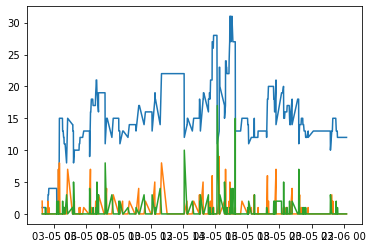

In [235]:
with pd.option_context('display.max_rows', 20, 'display.max_columns', None):
    display(df.query("vehicle_id == '2019'").sort_values(['block_abbr', 'scheduled_time']))

tdf = df.query("vehicle_id == '2019'").sort_values(['block_abbr', 'scheduled_time'])[['scheduled_time', 'ons', 'offs', 'load']]
fig, ax = plt.subplots()
ax.plot(tdf['scheduled_time'], tdf['load'])
ax.plot(tdf['scheduled_time'], tdf['ons'])
ax.plot(tdf['scheduled_time'], tdf['offs'])

In [236]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(df.query("trip_id == '259635'").sort_values([ 'vehicle_id', 'scheduled_time','stop_sequence']))

,trip_id,transit_date,arrival_time,scheduled_time,block_abbr,stop_sequence,stop_id_original,vehicle_id,vehicle_capacity,load,ons,offs,zero_load_at_trip_end,route_id,overload_id,route_id_dir
28579,259635,2022-03-05,2022-03-05 22:13:40,2022-03-05 22:15:00,1800,1,MCC4_13,1914,40.0,6.0,12.0,6.0,0,18,2,18_FROM DOWNTOWN
819,259635,2022-03-05,NaT,2022-03-05 22:15:29,1800,2,4AVDEASN,1914,40.0,6.0,0.0,0.0,0,18,2,18_FROM DOWNTOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,259635,2022-03-05,NaT,2022-03-05 22:42:17,1800,32,DONSHASM,2019,40.0,13.0,0.0,0.0,0,18,0,18_FROM DOWNTOWN
981,259635,2022-03-05,NaT,2022-03-05 22:47:00,1800,33,BNA,2019,40.0,13.0,0.0,0.0,0,18,0,18_FROM DOWNTOWN


## Creating trip plans, vehicle plans and schedules.
* For running on the simulator
* Remove the regular buses that the overload were covering, and change vehicle id of overload bus to the regular one

In [264]:
tdf.sort_values('vehicle_capacity')

,trip_id,transit_date,arrival_time,scheduled_time,block_abbr,stop_sequence,stop_id_original,vehicle_id,vehicle_capacity,load,ons,offs,zero_load_at_trip_end,route_id,overload_id,route_id_dir
7320,262506,2022-03-05,2022-03-05 08:24:18,2022-03-05 08:22:26,5002,15,CXISYLHE,737,15.0,3.0,0.0,0.0,1,50,0,50_TO DOWNTOWN
16001,262534,2022-03-05,2022-03-05 13:06:54,2022-03-05 13:04:08,5002,8,CHABALEF,737,15.0,10.0,0.0,0.0,1,50,0,50_TO DOWNTOWN
8649,262462,2022-03-05,2022-03-05 09:10:49,2022-03-05 09:10:00,5002,21,CXOANNEX,737,15.0,10.0,0.0,1.0,1,50,0,50_FROM DOWNTOWN
16011,262534,2022-03-05,2022-03-05 13:07:18,2022-03-05 13:04:50,5002,9,CHALELEM,737,15.0,10.0,0.0,0.0,1,50,0,50_TO DOWNTOWN
5986,262465,2022-03-05,2022-03-05 07:33:40,2022-03-05 07:33:47,5002,18,CXOAMERI,737,15.0,5.0,0.0,0.0,1,50,0,50_FROM DOWNTOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17094,263773,2022-03-05,2022-03-05 13:48:12,2022-03-05 13:42:14,5604,5,MAIMCFEN,121,45.0,45.0,0.0,0.0,0,56,0,56_FROM DOWNTOWN
5776,263793,2022-03-05,2022-03-05 07:27:22,2022-03-05 07:26:44,5602,30,GALEDENN,128,45.0,9.0,0.0,0.0,0,56,0,56_FROM DOWNTOWN
23846,263761,2022-03-05,2022-03-05 18:06:12,2022-03-05 18:05:07,5604,25,GALMAPNF,121,45.0,49.0,0.0,3.0,0,56,0,56_FROM DOWNTOWN
2689,263370,2022-03-05,2022-03-05 04:45:10,2022-03-05 04:46:32,5503,25,MXIPLUSP,141,45.0,3.0,1.0,0.0,1,55,0,55_TO DOWNTOWN


In [120]:
overload_trips = df.query("overload_id > 0").trip_id.unique()

In [119]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None):
    display(df.query("trip_id == '259635'"))

,trip_id,transit_date,arrival_time,scheduled_time,block_abbr,stop_sequence,stop_id_original,vehicle_id,vehicle_capacity,load,ons,offs,route_id,overload_id,route_id_dir
211,259635,2022-03-05,NaT,2022-03-05 22:24:58,1800,10,LAF1AEM,2019,40.0,13.0,0.0,0.0,18,0,18_FROM DOWNTOWN
237,259635,2022-03-05,NaT,2022-03-05 22:20:23,1800,8,NXOPBODY,2019,40.0,13.0,0.0,0.0,18,0,18_FROM DOWNTOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29033,259635,2022-03-05,2022-03-05 22:47:46,2022-03-05 22:42:17,1800,32,DONSHASM,1914,40.0,0.0,0.0,0.0,18,2,18_FROM DOWNTOWN
29063,259635,2022-03-05,2022-03-05 22:50:31,2022-03-05 22:47:00,1800,33,BNA,1914,40.0,0.0,0.0,0.0,18,2,18_FROM DOWNTOWN


In [237]:
def merge_overload_regular_bus_trips(regular, overload):
    m = regular.merge(overload, how='left', on=['trip_id', 'transit_date', 'scheduled_time', 'block_abbr', 'stop_sequence', 'stop_id_original', 'route_id_dir', 'route_id'])
    # m['load'] = np.max(m[['load_x', 'load_y']], axis=1)
    # m['ons'] = np.max(m[['ons_x', 'ons_y']], axis=1)
    # m['offs'] = np.max(m[['offs_x', 'offs_y']], axis=1)
    
    m['arrival_time'] = np.max(m[['arrival_time_x', 'arrival_time_y']], axis=1)
    
    # m['load'] = m['load_y']
    # m['ons'] = m['ons_y']
    # m['offs'] = m['offs_y']
    m['zero_load_at_trip_end'] = m['zero_load_at_trip_end_x']
    
    m.loc[~m['arrival_time_x'].isnull(), "load"] = m['load_x']
    m.loc[~m['arrival_time_x'].isnull(), "ons"] = m['ons_x']
    m.loc[~m['arrival_time_x'].isnull(), "offs"] = m['offs_x']
    
    m.loc[~m['arrival_time_y'].isnull(), "load"] = m['load_y']
    m.loc[~m['arrival_time_y'].isnull(), "ons"] = m['ons_y']
    m.loc[~m['arrival_time_y'].isnull(), "offs"] = m['offs_y']
    
    m['vehicle_id'] = m['vehicle_id_x']
    m['vehicle_capacity'] = m['vehicle_capacity_x']
    m['overload_id'] = m['overload_id_x']
    # m = m.drop(['load_x', 'load_y', 'ons_x', 'ons_y', 'offs_x', 'offs_y', 'arrival_time_x', 'arrival_time_y'], axis=1)
    m = m[m.columns.drop(list(m.filter(regex='_x')))]
    m = m[m.columns.drop(list(m.filter(regex='_y')))]
    m = m[regular.columns]
    return m

a = df.query("trip_id == '259845' and vehicle_id == '1818'").sort_values('stop_sequence')
b = df.query("trip_id == '259845' and vehicle_id == '2008'").sort_values('stop_sequence')
m1 = merge_overload_regular_bus_trips(a, b)

a = df.query("trip_id == '259635' and vehicle_id == '2019'").sort_values('stop_sequence')
b = df.query("trip_id == '259635' and vehicle_id == '1914'").sort_values('stop_sequence')
m2 = merge_overload_regular_bus_trips(a, b)

tdf = df.query("overload_id == 0")
tdf = tdf[~tdf['trip_id'].isin(overload_trips)]
tdf = pd.concat([tdf, m1, m2])

In [238]:
m2.head()

,trip_id,transit_date,arrival_time,scheduled_time,block_abbr,stop_sequence,stop_id_original,vehicle_id,vehicle_capacity,load,ons,offs,zero_load_at_trip_end,route_id,overload_id,route_id_dir
0,259635,2022-03-05,2022-03-05 22:43:23,2022-03-05 22:15:00,1800,1,MCC4_13,2019,40.0,6.0,12.0,6.0,0,18,0,18_FROM DOWNTOWN
1,259635,2022-03-05,NaT,2022-03-05 22:15:29,1800,2,4AVDEASN,2019,40.0,NaN,NaN,NaN,0,18,0,18_FROM DOWNTOWN
2,259635,2022-03-05,NaT,2022-03-05 22:15:51,1800,3,4AVUNISN,2019,40.0,NaN,NaN,NaN,0,18,0,18_FROM DOWNTOWN
3,259635,2022-03-05,NaT,2022-03-05 22:16:07,1800,4,4AARCADE,2019,40.0,NaN,NaN,NaN,0,18,0,18_FROM DOWNTOWN
4,259635,2022-03-05,2022-03-05 22:19:30,2022-03-05 22:16:31,1800,5,4AVCHUSN,2019,40.0,6.0,0.0,0.0,0,18,0,18_FROM DOWNTOWN


In [239]:
# tdf[~tdf['arrival_time'].isnull()].query("trip_id == '263370'")

# Generate trip and vehicle plan json files

In [260]:
import copy
import json

trip_res_df = copy.copy(tdf)
DEFAULT_CAPACITY = 40.0

overall_vehicle_plan = {}

# TODO: run again with vehicle_capacity (above)
for vehicle_id, vehicle_df in trip_res_df.groupby('vehicle_id'):
    vehicle_df = vehicle_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
    vehicle_capacity = vehicle_df.iloc[0].vehicle_capacity
    if np.isnan(vehicle_capacity):
        vehicle_capacity = DEFAULT_CAPACITY
    # TODO: This is not the baseline behavior
    starting_depot = 'MCC5_1'
    service_type = 'regular'
    blocks = [block for block in vehicle_df.block_abbr.unique().tolist()]
    trips = []
    for block in blocks:
        block_df = vehicle_df.query("block_abbr == @block")
        for trip in block_df.trip_id.unique().tolist():
            trips.append((str(block), str(trip)))
    overall_vehicle_plan[vehicle_id] = {'vehicle_capacity': vehicle_capacity, 'trips': trips, 'starting_depot': starting_depot, 'service_type': service_type}

OVERLOAD_BUSES = 5
for vehicle_id in range(41, 41 + OVERLOAD_BUSES):
    overall_vehicle_plan[str(vehicle_id)] = {'vehicle_capacity': 55.0, 'trips': [], "starting_depot": "MCC5_1", 'service_type': "overload"}
    
with open(f'results/vehicle_plan_{DATE.replace("-", "")}.json', 'w') as fp:
    json.dump(overall_vehicle_plan, fp, sort_keys=True, indent=2)
overall_vehicle_plan['1818']

{'vehicle_capacity': 40.0,
 'trips': [('1900', '259828'),
  ('1900', '259824'),
  ('1900', '259851'),
  ('1900', '259820'),
  ('1900', '259847'),
  ('1900', '259818'),
  ('1900', '259845')],
 'starting_depot': 'MCC5_1',
 'service_type': 'regular'}

In [261]:
overall_block_plan = {}
for block_abbr, block_df in trip_res_df.groupby('block_abbr'):
    block_df = block_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
    trip_ids = block_df.trip_id.unique().tolist()
    start_time = block_df[block_df['trip_id'] == trip_ids[0]].iloc[0]['scheduled_time'].strftime('%Y-%m-%d %H:%M:%S')
    end_time = block_df[block_df['trip_id'] == trip_ids[-1]].iloc[-1]['scheduled_time'].strftime('%Y-%m-%d %H:%M:%S')
    overall_block_plan[block_abbr] = {'trip_ids': trip_ids,
                                    'start_time': start_time,
                                    'end_time': end_time}

overall_trip_plan = {}
for trip_id, trip_df in trip_res_df.groupby('trip_id'):
    trip_df = trip_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
    route_id_dir = trip_df.iloc[0].route_id_dir
    route_id = int(route_id_dir.split("_")[0])
    route_direction = route_id_dir.split("_")[1]
    zero_load_at_trip_end = trip_df.iloc[-1].zero_load_at_trip_end.tolist()
    scheduled_time = trip_df.scheduled_time.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
    stop_sequence = trip_df.stop_sequence.tolist()
    stop_sequence = list(range(0, len(stop_sequence)))
    stop_id_original = trip_df.stop_id_original.tolist()
    
    overall_trip_plan[trip_id] = {'route_id': route_id, 
                                'route_direction': route_direction, 
                                'scheduled_time': scheduled_time, 
                                'stop_sequence': stop_sequence, 
                                'stop_id_original': stop_id_original,
                                'zero_load_at_trip_end':zero_load_at_trip_end,
                                'last_stop_sequence': stop_sequence[-1],
                                'last_stop_id': stop_id_original[-1]}

with open(f'results/trip_plan_{DATE.replace("-", "")}.json', 'w') as fp:
    json.dump(overall_trip_plan, fp, sort_keys=True, indent=2)
overall_trip_plan['259635']

{'route_id': 18,
 'route_direction': 'FROM DOWNTOWN',
 'scheduled_time': ['2022-03-05 22:15:00',
  '2022-03-05 22:16:31',
  '2022-03-05 22:17:09',
  '2022-03-05 22:18:48',
  '2022-03-05 22:20:23',
  '2022-03-05 22:21:45',
  '2022-03-05 22:24:58',
  '2022-03-05 22:26:00',
  '2022-03-05 22:26:40',
  '2022-03-05 22:27:19',
  '2022-03-05 22:28:38',
  '2022-03-05 22:29:29',
  '2022-03-05 22:29:51',
  '2022-03-05 22:31:31',
  '2022-03-05 22:31:49',
  '2022-03-05 22:32:37',
  '2022-03-05 22:33:04',
  '2022-03-05 22:33:45',
  '2022-03-05 22:34:25',
  '2022-03-05 22:35:00',
  '2022-03-05 22:35:23',
  '2022-03-05 22:36:09',
  '2022-03-05 22:37:32',
  '2022-03-05 22:38:42',
  '2022-03-05 22:39:18',
  '2022-03-05 22:40:18',
  '2022-03-05 22:40:44',
  '2022-03-05 22:41:44',
  '2022-03-05 22:42:17',
  '2022-03-05 22:47:00'],
 'stop_sequence': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  

In [299]:
# Sample loads
trip_res = copy.copy(tdf)
sampled_ons_offs = []
for trip_id, trip_id_df in trip_res.groupby(['transit_date', 'trip_id']):
    _tdf = trip_id_df.sort_values('stop_sequence').reset_index(drop=True)
    _tdf = _tdf.dropna(subset=['arrival_time'])
    _tdf['stop_sequence'] = list(range(1, len(_tdf) + 1))
    _tdf = _tdf.rename({'load':'sampled_loads'}, axis=1)
    sampled_ons_offs.append(_tdf)

df = pd.concat(sampled_ons_offs)
df['key_pair'] = list(zip(df.route_id_dir, 
                          df.block_abbr,
                          df.stop_sequence,
                          df.stop_id_original, 
                          df.scheduled_time))
df = df.set_index('key_pair')
sampled_ons_offs_dict = df.drop(['trip_id', 'route_id_dir', 'block_abbr', 'stop_id_original', 
                                'scheduled_time', 'transit_date', 'arrival_time', 
                                'zero_load_at_trip_end', 'route_id', 'overload_id',
                                'vehicle_capacity', 'vehicle_id',
                                'stop_sequence'], axis=1).to_dict('index')

with open(f'results/sampled_ons_offs_dict_{DATE.replace("-", "")}.pkl', 'wb') as handle:
    pickle.dump(sampled_ons_offs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Creating timepoint dict

In [263]:
def fix_time(x):
    if x[0:2] == '24':
        return '00'+x[2:]
    if x[0:2] == '25':
        return '01'+x[2:]
    if x[0:2] == '26':
        return '02'+x[2:]
    if x[0:2] == '27':
        return '03'+x[2:]
    return x

stop_times_fp = 'data/GTFS/JAN2022/stop_times.txt'
stop_times_df = pd.read_csv(stop_times_fp)
stop_times_df['date'] = DATE
stop_times_df['arrival_time'] = stop_times_df['arrival_time'].apply(lambda x: fix_time(x))
stop_times_df['scheduled_time'] = pd.to_datetime(stop_times_df['date'] + ' ' + stop_times_df['arrival_time'])

stop_times_df['key_pair'] = list(zip(stop_times_df.trip_id, stop_times_df.stop_id, stop_times_df.scheduled_time))
stop_times_df = stop_times_df.set_index('key_pair')

time_point_dict = stop_times_df.drop(['arrival_time', 'departure_time', 'stop_id', 'stop_sequence', 'stop_headsign', 'trip_id',
                                        'pickup_type', 'drop_off_type', 'shape_dist_traveled', 'scheduled_time', 'date'], axis=1).to_dict('index')
with open(f'results/time_point_dict_{DATE.replace("-", "")}.pkl', 'wb') as handle:
    pickle.dump(time_point_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
time_point_dict

{(259274, 'MCC4_20', Timestamp('2022-03-05 14:15:00')): {'timepoint': 1},
 (259274, 'UNI2AEF', Timestamp('2022-03-05 14:16:28')): {'timepoint': 0},
 (259274, '1SWOONM', Timestamp('2022-03-05 14:18:12')): {'timepoint': 0},
 (259274, '1SJAMNM', Timestamp('2022-03-05 14:19:07')): {'timepoint': 0},
 (259274, 'N1SOLDNM', Timestamp('2022-03-05 14:19:55')): {'timepoint': 0},
 (259274, 'DICGRANN', Timestamp('2022-03-05 14:22:07')): {'timepoint': 0},
 (259274, 'DICHANNN', Timestamp('2022-03-05 14:22:29')): {'timepoint': 0},
 (259274, 'DICCLENN', Timestamp('2022-03-05 14:23:19')): {'timepoint': 0},
 (259274, 'WHIDICNF', Timestamp('2022-03-05 14:24:00')): {'timepoint': 1},
 (259274, 'FERBRIWN', Timestamp('2022-03-05 14:25:16')): {'timepoint': 0},
 (259274, 'BAPVASWN', Timestamp('2022-03-05 14:26:02')): {'timepoint': 0},
 (259274, 'BAPWEANN', Timestamp('2022-03-05 14:26:29')): {'timepoint': 0},
 (259274, 'BAPLOCNM', Timestamp('2022-03-05 14:27:00')): {'timepoint': 0},
 (259274, 'BAPSEMNN', Timesta

In [319]:
# Sanity check

In [311]:
fp = '/home/jptalusan/gits/mta_simulator_redo/data_generation/results/gtfs_distance_pairs_km.pkl'
dist_pairs = pd.read_pickle(fp)
dist_pairs.query("stop_id == 'GXIRIVEF' and next_stop_id == 'GXIMYASF'")

,stop_id,next_stop_id,shape_dist_traveled_km
52048,GXIRIVEF,GXIMYASF,0.6965


In [339]:

a = tdf.query("vehicle_id == '2019'").sort_values('scheduled_time').dropna(subset='arrival_time')
a['next_stop'] = a['stop_id_original'].shift(-1)
a = a.merge(dist_pairs, right_on=['stop_id', 'next_stop_id'], left_on=['stop_id_original', 'next_stop']).sort_values('scheduled_time')
# a.shape_dist_traveled_km.sum(), a.ons.sum()
a.ons.sum()

251.0

In [331]:
tdf.query("trip_id == '259667'")

,trip_id,transit_date,arrival_time,scheduled_time,block_abbr,stop_sequence,stop_id_original,vehicle_id,vehicle_capacity,load,ons,offs,zero_load_at_trip_end,route_id,overload_id,route_id_dir
155,259667,2022-03-05,NaT,2022-03-05 08:11:13,1800,8,JAM5AEN,2019,40.0,13.0,0.0,0.0,1,18,0,18_TO DOWNTOWN
180,259667,2022-03-05,NaT,2022-03-05 08:09:27,1800,6,8ABRONM,2019,40.0,13.0,0.0,0.0,1,18,0,18_TO DOWNTOWN
667,259667,2022-03-05,NaT,2022-03-05 08:09:18,1800,5,8ABRONN,2019,40.0,13.0,0.0,0.0,1,18,0,18_TO DOWNTOWN
800,259667,2022-03-05,NaT,2022-03-05 08:11:25,1800,9,JAMGAYSN,2019,40.0,13.0,0.0,0.0,1,18,0,18_TO DOWNTOWN
1273,259667,2022-03-05,NaT,2022-03-05 08:08:58,1800,4,8ADEMNN,2019,40.0,13.0,0.0,0.0,1,18,0,18_TO DOWNTOWN
1543,259667,2022-03-05,NaT,2022-03-05 08:08:00,1800,2,KOR4AVWN,2019,40.0,13.0,0.0,0.0,1,18,0,18_TO DOWNTOWN
1782,259667,2022-03-05,NaT,2022-03-05 08:08:22,1800,3,KOR6AVWN,2019,40.0,13.0,0.0,0.0,1,18,0,18_TO DOWNTOWN
2523,259667,2022-03-05,NaT,2022-03-05 08:10:52,1800,7,JAM7AVEN,2019,40.0,13.0,0.0,0.0,1,18,0,18_TO DOWNTOWN
6240,259667,2022-03-05,2022-03-05 07:44:11,2022-03-05 07:50:00,1800,1,BNA,2019,40.0,13.0,1.0,0.0,1,18,0,18_TO DOWNTOWN
6801,259667,2022-03-05,2022-03-05 08:03:13,2022-03-05 08:12:00,1800,10,MCC4_13,2019,40.0,9.0,0.0,4.0,1,18,0,18_TO DOWNTOWN


In [337]:
tdf.query("vehicle_id == '2019'").sort_values('scheduled_time').dropna(subset='arrival_time').ons.sum()

207.0